<h3>Seminário - Trabalho Final para a disciplina Ciência de dados</h3>
<h4>Tema: Modelo de Regressão Linear Múltipla para previsão de safra agrícola.</h4>

<p>Autores: Guilherme Lima Zanin e João Lucas Criveli</p>
<p>Docente: Prof. Dr. Clayton Reginaldo Pereira</p>


<p>O objetivo deste notebook é apresentar o processo de treinamento de um modelo que será utilizado para previsão do rendimento de safras agrícolas. Ao final do treinamento, almeja-se um modelo que, a partir das informações da área plantada (em hectares) e em qual estado brasileiro a plantação está localizada, retorne uma estimativa da aŕea que será colhida e do valor da produção.</p>

<h4>Informações do dataset</h4>

<p>O dataset foi retirado a partir da Tabela 1612: - Área plantada, área colhida, quantidade produzida, rendimento médio e valor da produção das lavouras temporárias, disponível em https://sidra.ibge.gov.br/tabela/1612 (Acesso em 22/06/2025). O dataset consta com as seguintes variáveis: Área plantada (hectares), Área plantada - percentual do total, Área colhida, Área colhida - percentual do total, Quantidade produzida (toneladas), valor da produção (reais), valor da produção - percentual do total geral. Para cada variável, há valores dos anos de 2010 até 2023, para todos os estados brasilieiros. Foi selecionada uma cultura para o treinamento dos modelos - a soja, resultado no dataset "tabela1612_soja.csv"</p>

In [66]:
import pandas as pd
import numpy as np

#Carregando os datasets
df_soja = pd.read_csv('tabela1612_soja.csv', sep=';')


# Substitui o símbolo '-' por NaN
# Conforme a legenda, '-' indica zero absoluto (não numérico)
df_soja.loc[:, 'Valor'] = df_soja['Valor'].replace('-', np.nan)


# Converte a coluna 'Valor' para numérico
# Usa errors='coerce' para converter strings numéricas e marcar valores inválidos como NaN
df_soja.loc[:, 'Valor'] = pd.to_numeric(df_soja['Valor'], errors='coerce')



In [67]:
#Pivotamento da tabela - operação realizada para que cada linha tenha um estado e um ano
df_pivot_soja = df_soja.pivot_table(index=['Unidade da Federação', 'Ano'], 
                               columns='Variável', 
                               values='Valor',
                               aggfunc='first').reset_index()

df_pivot_soja.head(5)

Variável,Unidade da Federação,Ano,Quantidade produzida (Toneladas),Valor da produção (Mil Reais),Área colhida (Hectares),Área plantada (Hectares)
0,Acre,2010,330.0,219.0,100.0,100.0
1,Acre,2011,282.0,197.0,85.0,85.0
2,Acre,2013,154.0,129.0,57.0,60.0
3,Acre,2014,1095.0,926.0,400.0,400.0
4,Acre,2016,150.0,195.0,100.0,100.0


In [68]:
# Renomeia colunas para clareza
# Inclui Área Colhida como variável independente
df_pivot_soja = df_pivot_soja[['Unidade da Federação', 'Ano', 'Área plantada (Hectares)', 
                     'Área colhida (Hectares)', 'Quantidade produzida (Toneladas)', 
                     'Valor da produção (Mil Reais)']]
df_pivot_soja.columns = ['Estado', 'Ano', 'Area_Plantada', 'Area_Colhida', 
                    'Quantidade_Produzida', 'Valor_Producao']


df_pivot_soja.head(5)

,Estado,Ano,Area_Plantada,Area_Colhida,Quantidade_Produzida,Valor_Producao
0,Acre,2010,100.0,100.0,330.0,219.0
1,Acre,2011,85.0,85.0,282.0,197.0
2,Acre,2013,60.0,57.0,154.0,129.0
3,Acre,2014,400.0,400.0,1095.0,926.0
4,Acre,2016,100.0,100.0,150.0,195.0


In [69]:
# Conversão de valores
# Converte colunas para numérico
numeric_columns = ['Ano', 'Area_Plantada', 'Area_Colhida', 'Quantidade_Produzida', 'Valor_Producao']
for col in numeric_columns:
    df_pivot_soja[col] = pd.to_numeric(df_pivot_soja[col], errors='coerce')

In [70]:
# Tratando valores Nan

# Total de valores NaN por coluna
print(df_pivot_soja.isna().sum())

# Removendo linhas com valores NaN
df_pivot_soja = df_pivot_soja.dropna()

Estado                  0
Ano                     0
Area_Plantada           0
Area_Colhida            1
Quantidade_Produzida    1
Valor_Producao          1
dtype: int64


In [71]:
#Salvando os DataFrames tratados em arquivos CSV
df_pivot_soja.to_csv('tabela1612_soja_tratada.csv', index=False, sep=';')

<h4>Explicando a técnica utilizada</h4>

A regressão linear múltipla é um método estatístico que modela a relação entre uma variável dependente (neste caso, quantidade produzida ou valor da produção) e várias variáveis independentes (área plantada e estado). A equação geral é:

$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p + \epsilon $

onde $ y $ é a variável dependente, $ x_1, x_2, \dots, x_p $ são as variáveis independentes, $ \beta_0, \beta_1, \dots, \beta_p $ são os coeficientes estimados, e $ \epsilon $ é o erro. Os coeficientes são calculados minimizando a soma dos quadrados dos resíduos.

In [72]:
# Importando as bibliotecas utilizadas no treinamento

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [73]:

# Define as variáveis independentes (X) e dependentes (y)
# Usa Área Plantada, Ano e Estado como features
X = df_pivot_soja[['Estado', 'Area_Plantada', 'Ano']]
y_quantidade = df_pivot_soja['Quantidade_Produzida']
y_area_colhida = df_pivot_soja['Area_Colhida']

In [74]:
# Configura o pré-processamento
preprocessor = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['Estado']),
    ('scaler', StandardScaler(), ['Ano', 'Area_Plantada'])
])

X_preprocessed = preprocessor.fit_transform(X)

In [75]:
# Divide os dados em treino (80%) e teste (20%)
X_train, X_test, y_quantidade_train, y_quantidade_test = train_test_split(
    X_preprocessed, y_quantidade, test_size=0.2, random_state=42)
X_train, X_test, y_area_colhida_train, y_area_colhida_test = train_test_split(
    X_preprocessed, y_area_colhida, test_size=0.2, random_state=42)

In [76]:
# Treina o modelo para quantidade produzida
modelo_quantidade = LinearRegression()
modelo_quantidade.fit(X_train, y_quantidade_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [77]:
# Treina o modelo para area colhida
modelo_area_colhida = LinearRegression()
modelo_area_colhida.fit(X_train, y_area_colhida_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [78]:
# Faz previsões no conjunto de teste
y_quantidade_pred = modelo_quantidade.predict(X_test)
y_area_colhida_pred = modelo_area_colhida.predict(X_test)

In [79]:
# Garante que previsões de quantidade sejam não negativas
negatives = (y_quantidade_pred < 0).sum()
if negatives > 0:
    print(f"Aviso: {negatives} previsões negativas detectadas para Quantidade Produzida. Aplicando max(0, previsão).")
y_quantidade_pred = np.maximum(0, y_quantidade_pred)

Aviso: 4 previsões negativas detectadas para Quantidade Produzida. Aplicando max(0, previsão).


In [80]:
# Calcula métricas
mse_quantidade = mean_squared_error(y_quantidade_test, y_quantidade_pred)
r2_quantidade = r2_score(y_quantidade_test, y_quantidade_pred)
mse_area_colhida = mean_squared_error(y_area_colhida_test, y_area_colhida_pred)
r2_area_colhida = r2_score(y_area_colhida_test, y_area_colhida_pred)

In [81]:
# Imprime métricas
print('Erro Quadrático Médio (Quantidade):', mse_quantidade)
print('R² (Quantidade):', r2_quantidade)
print('Erro Quadrático Médio (Área Colhida):', mse_area_colhida)
print('R² (Área Colhida):', r2_area_colhida)

Erro Quadrático Médio (Quantidade): 2461662352880.3696
R² (Quantidade): 0.942415359374707
Erro Quadrático Médio (Área Colhida): 444540571.60342693
R² (Área Colhida): 0.9998974184375522


In [82]:
# Salva os dados de treino e teste
X_train_df = pd.DataFrame(X_train.toarray() if hasattr(X_train, 'toarray') else X_train, 
                         columns=preprocessor.get_feature_names_out())
X_test_df = pd.DataFrame(X_test.toarray() if hasattr(X_test, 'toarray') else X_test, 
                        columns=preprocessor.get_feature_names_out())
train_data_quantidade = pd.concat([X_train_df, y_quantidade_train.reset_index(drop=True)], axis=1)
test_data_quantidade = pd.DataFrame({'y_quantidade_test': y_quantidade_test, 
                                   'y_quantidade_pred': y_quantidade_pred})

train_data_area_colhida = pd.concat([X_train_df, y_area_colhida_train.reset_index(drop=True)], axis=1)
test_data_area_colhida = pd.DataFrame({'y_area_colhida_test': y_area_colhida_test, 
                                       'y_area_colhida_pred': y_area_colhida_pred})

train_data_quantidade.to_csv('resultados/train_data_quantidade.csv', index=False)
test_data_quantidade.to_csv('resultados/test_data_quantidade.csv', index=False)

train_data_area_colhida.to_csv('resultados/train_data_area_colhida.csv', index=False)
test_data_area_colhida.to_csv('resultados/test_data_area_colhida.csv', index=False)

# Salva as métricas
metricas = pd.DataFrame({
    'Modelo': ['Quantidade', 'Área Colhida'],
    'MSE': [mse_quantidade, mse_area_colhida],
    'R2': [r2_quantidade, r2_area_colhida]
})
metricas.to_csv('resultados/metricas.csv', index=False)

In [83]:
import joblib

# Salva os modelos e o transformador
joblib.dump(modelo_quantidade, 'resultados/modelo_quantidade.pkl')
joblib.dump(modelo_area_colhida, 'resultados/modelo_area_colhida.pkl')
joblib.dump(preprocessor, 'resultados/column_transformer.pkl')

['resultados/column_transformer.pkl']

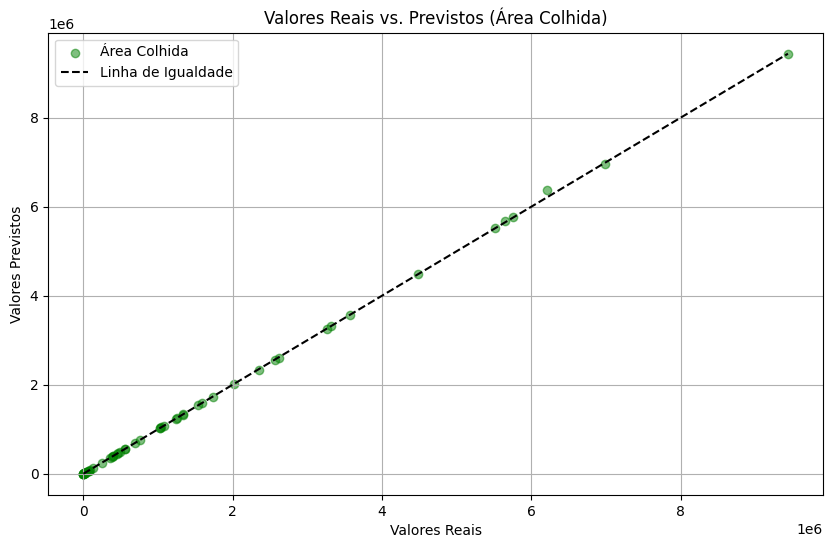

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Plot 1: Gráfico de dispersão (valores reais vs. previstos)
plt.figure(figsize=(10, 6))
plt.scatter(y_area_colhida_test, y_area_colhida_pred, color='green', alpha=0.5, label='Área Colhida')
plt.plot([min(y_area_colhida_test.min(), y_area_colhida_pred.min()), 
          max(y_area_colhida_test.max(), y_area_colhida_pred.max())], 
         [min(y_area_colhida_test.min(), y_area_colhida_pred.min()), 
          max(y_area_colhida_test.max(), y_area_colhida_pred.max())], 
         color='black', linestyle='--', label='Linha de Igualdade')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Previstos (Área Colhida)')
plt.legend()
plt.grid(True)
plt.savefig('resultados/dispersao_reais_vs_prevision.png')
plt.show()

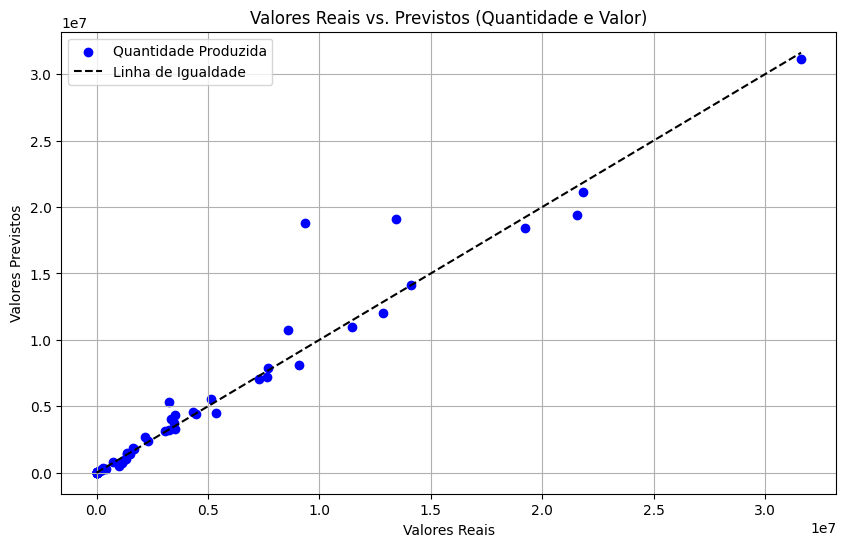

In [85]:
# Plot 1: Gráfico de dispersão (valores reais vs. previstos)
plt.figure(figsize=(10, 6))
plt.scatter(y_quantidade_test, y_quantidade_pred, color='blue', label='Quantidade Produzida')
plt.plot([min(y_quantidade_test.min(), y_quantidade_pred.min()), 
          max(y_quantidade_test.max(), y_quantidade_pred.max())], 
         [min(y_quantidade_test.min(), y_quantidade_pred.min()), 
          max(y_quantidade_test.max(), y_quantidade_pred.max())], 
         color='black', linestyle='--', label='Linha de Igualdade')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Valores Reais vs. Previstos (Quantidade e Valor)')
plt.legend()
plt.grid(True)
plt.savefig('resultados/dispersao_reais_vs_prevision.png')
plt.show()

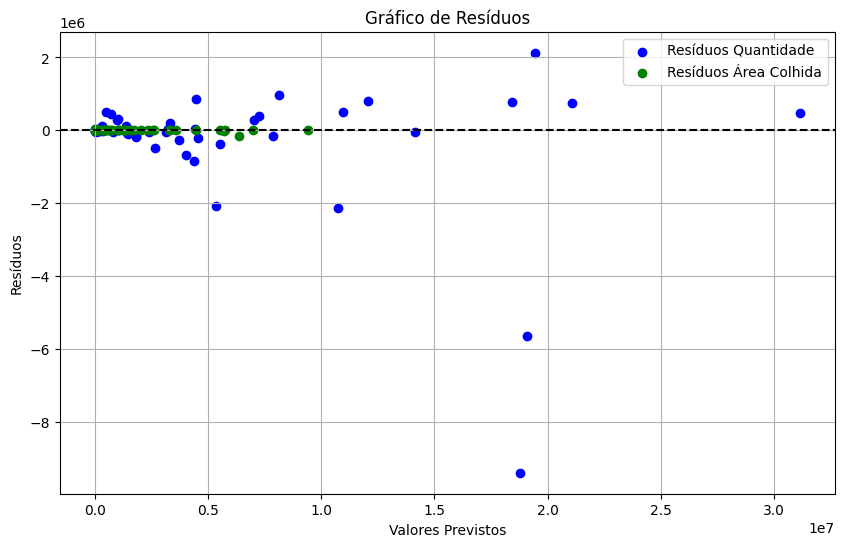

In [86]:
# Plot 2: Gráfico de resíduos
residuos_quantidade = y_quantidade_test - y_quantidade_pred
residuos_area_colhida = y_area_colhida_test - y_area_colhida_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_quantidade_pred, residuos_quantidade, color='blue', label='Resíduos Quantidade')
plt.scatter(y_area_colhida_pred, residuos_area_colhida, color='green', label='Resíduos Área Colhida')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.title('Gráfico de Resíduos')
plt.legend()
plt.grid(True)
plt.savefig('resultados/grafico_residuos.png')
plt.show()

In [87]:
# Testa previsões para diferentes estados com mesmos valores
estados_teste = ['São Paulo', 'Mato Grosso', 'Paraná']
novos_dados = pd.DataFrame({
    'Estado': estados_teste,
    'Ano': [2025] * len(estados_teste),
    'Area_Plantada': [3694468.0] * len(estados_teste),
})

print(novos_dados.head(3))
novos_dados_encoded = preprocessor.transform(novos_dados)
quantidade_prevista = modelo_quantidade.predict(novos_dados_encoded)
area_colhida_prevista = modelo_area_colhida.predict(novos_dados_encoded)

# Imprime previsões para diferentes estados
print("\nPrevisões para diferentes estados (Ano=2023, Área Plantada=100000, Área Colhida=100000):")
for estado, qtd, area in zip(estados_teste, quantidade_prevista, area_colhida_prevista):
    print(f"{estado}: Quantidade = {qtd:.2f} toneladas, Área Colhida = {area:.2f} hectares")

        Estado   Ano  Area_Plantada
0    São Paulo  2025      3694468.0
1  Mato Grosso  2025      3694468.0
2       Paraná  2025      3694468.0

Previsões para diferentes estados (Ano=2023, Área Plantada=100000, Área Colhida=100000):
São Paulo: Quantidade = 14392360.36 toneladas, Área Colhida = 3696166.86 hectares
Mato Grosso: Quantidade = 7798158.80 toneladas, Área Colhida = 3677696.02 hectares
Paraná: Quantidade = 11019632.94 toneladas, Área Colhida = 3691825.15 hectares


<h3>Análise exploratória dos dados</h3>

<p>Iremos aplicar dois testes de hipótese para buscar alguns padrões nos dados agrícolas.</p>

<h4>Teste 1: Significado da Área Plantada na Quantidade Produzida</h4>
<p>Este teste verifica se a área plantada tem um efeito significativo na quantidade produzida. A ideia é entender se aumentar a área plantada realmente aumenta a produção, o que é crucial para planejamento agrícola. Usamos um teste t para o coeficiente da área plantada, comparando a hipótese nula (nenhum efeito) com a alternativa (há efeito). Se o p-valor for menor que 0,05, rejeitamos a hipótese nula, indicando um impacto significativo.</p>

<h4>Teste 2: Significado geral do modelo para área colhida</h4>

<p>Aqui, testamos se o modelo como um todo explica bem as variações na área colhida, usando as variáveis área plantada, estado e ano. A hipótese nula é que nenhuma variável tem efeito, e a alternativa é que pelo menos uma tem. Usamos o teste F, e se o p-valor for menor que 0,05, rejeitamos a hipótese nula, mostrando que o modelo é útil para prever a área colhida.</p>

In [88]:
import statsmodels.formula.api as smf

# Teste 1: Significado da Area_Plantada na Quantidade_Produzida

model_quantidade = smf.ols('Quantidade_Produzida ~ Area_Plantada', data=df_pivot_soja).fit()
p_value_area_plantada = model_quantidade.pvalues['Area_Plantada']
print(f"P-valor para Area_Plantada na Quantidade_Produzida: {p_value_area_plantada}")
if p_value_area_plantada < 0.05:
    print("Rejeita H0: Area_Plantada tem efeito significativo na Quantidade_Produzida.")
else:
    print("Não rejeita H0: Sem efeito significativo de Area_Plantada na Quantidade_Produzida.")

P-valor para Area_Plantada na Quantidade_Produzida: 7.757819123081476e-207
Rejeita H0: Area_Plantada tem efeito significativo na Quantidade_Produzida.


In [89]:
# Teste 2: Significado geral do modelo para Area_Colhida

model_area_colhida_geral = smf.ols('Area_Colhida ~ Area_Plantada + C(Estado) + Ano', data=df_pivot_soja).fit()
p_value_f_stat = model_area_colhida_geral.f_pvalue
print(f"\nTeste 2 - P-valor do teste F para o modelo Area_Colhida: {p_value_f_stat}")
if p_value_f_stat < 0.05:
    print("Rejeita H0: O modelo para Area_Colhida é estatisticamente significativo.")
else:
    print("Não rejeita H0: O modelo para Area_Colhida não é estatisticamente significativo.")


# Analisando a relevância de cada variável no modelo de soja

model_area_colhida_area_plantada = smf.ols('Area_Colhida ~ Area_Plantada ', data=df_pivot_soja).fit()
p_value_f_stat = model_area_colhida_area_plantada.f_pvalue
print(f"\nÁrea plantada - P-valor do teste F para o modelo Area_Colhida: {p_value_f_stat}")
if p_value_f_stat < 0.05:
    print("Rejeita H0: A influência da Área Plantada na Área Colhida é estatisticamente significativa.")
else:
    print("Não rejeita H0: Não há influência estatisticamente significativa da Área Plantada na Área Colhida.")


model_area_colhida_estado = smf.ols('Area_Colhida ~ C(Estado)', data=df_pivot_soja).fit()
p_value_f_stat = model_area_colhida_estado.f_pvalue
print(f"\nEstado - P-valor do teste F para o modelo Area_Colhida: {p_value_f_stat}")
if p_value_f_stat < 0.05:
    print("Rejeita H0: A influência do Estado na Área Colhida é estatisticamente significativa.")
else:
    print("Não rejeita H0: Não há influência estatisticamente significativa do Estado na Área Colhida.")

model_area_colhida_ano = smf.ols('Area_Colhida ~ Ano', data=df_pivot_soja).fit()
p_value_f_stat = model_area_colhida_ano.f_pvalue
print(f"\nAno - P-valor do teste F para o modelo Area_Colhida: {p_value_f_stat}")
if p_value_f_stat < 0.05:
    print("Rejeita H0: A influência do Ano na Área Colhida é estatisticamente significativa.")
else:
    print("Não rejeita H0: Não há influência estatisticamente significativa do Ano na Área Colhida.")


Teste 2 - P-valor do teste F para o modelo Area_Colhida: 0.0
Rejeita H0: O modelo para Area_Colhida é estatisticamente significativo.

Área plantada - P-valor do teste F para o modelo Area_Colhida: 0.0
Rejeita H0: A influência da Área Plantada na Área Colhida é estatisticamente significativa.

Estado - P-valor do teste F para o modelo Area_Colhida: 1.0809788259570328e-160
Rejeita H0: A influência do Estado na Área Colhida é estatisticamente significativa.

Ano - P-valor do teste F para o modelo Area_Colhida: 0.26743772318861386
Não rejeita H0: Não há influência estatisticamente significativa do Ano na Área Colhida.
